In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
try:
    import pandas_datareader as web
    import cvxopt as opt
    from cvxopt import solvers

except:
    !pip install pandas_datareader 
    !pip install cvxopt
    import pandas_datareader as web


In [64]:
#GMV Portfolio

ticker = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
start_date = '2010-06-29'
end_date = '2022-06-30'

data = web.get_data_yahoo(ticker, start_date, end_date)['Adj Close'].dropna()

ret = data.pct_change().dropna()
data = data/data.iloc[0] * 100


In [15]:
rf = web.get_data_yahoo('TLT', '2010-06-28', '2022-06-30')['Adj Close'].pct_change().dropna()
rf_rate = rf.mean() * 252

In [16]:
rf_rate

0.04824685429242884

In [17]:
data.head(10)

Symbols,AAPL,GOOGL,MSFT,AMZN,TSLA
Date,,,,,
2010-06-29,100.000000,100.000000,100.000000,100.000000,100.000000
2010-06-30,98.188677,97.950509,98.713004,100.598468,99.748847
2010-07-01,96.998081,96.748557,99.356476,102.163702,91.921312
2010-07-02,96.396903,96.101353,99.828383,100.487980,80.368355
2010-07-06,97.056630,95.995682,102.187887,101.335047,67.434072
2010-07-07,100.975881,99.106234,104.247080,104.437900,66.136462
2010-07-08,100.749456,100.506319,104.718988,107.006718,73.084977
2010-07-09,101.346732,102.912425,104.118376,107.964274,72.833824
2010-07-12,100.437166,104.748380,106.520792,110.035910,71.368777


In [7]:
#Feasible Set
n = len(data.columns)
returns = []
stds = []
wgt = []
count = 1000000

tr = 0

In [8]:
for i in range(count):
    weights = np.random.random(n)
    weights /= sum(weights)
    wgt.append(weights)
    mean = np.sum(weights * ret.mean()*252)  # *252로 1년 수익률 계산
    var = np.dot(weights.T, np.dot(ret.cov()*252, weights))
    cov = np.sqrt(var)
    returns.append(mean)
    stds.append(cov)
    tr += 1

In [9]:
wgt2 = pd.DataFrame(wgt, columns = data.columns)
sharpe = np.array(returns)/np.array(stds)
tangent = (np.array(returns)- rf_rate)/np.array(stds)
dt = {'Returns':returns, 'Stds': stds, 'Sharpe' : sharpe, 'Tangent' : tangent}
dt = pd.DataFrame(dt)

eff = pd.concat([dt,wgt2], axis = 1)

eff

,Returns,Stds,Sharpe,Tangent,AAPL,GOOGL,MSFT,AMZN,TSLA
0,0.328813,0.257072,1.279072,1.091394,0.248901,0.126237,0.380964,0.020289,0.223608
1,0.340082,0.261095,1.302520,1.117733,0.293049,0.002514,0.285628,0.201202,0.217607
2,0.319227,0.248367,1.285305,1.091048,0.298237,0.167381,0.166466,0.199677,0.168238
3,0.272077,0.230325,1.181276,0.971803,0.158171,0.245155,0.335766,0.225354,0.035554
4,0.289280,0.235519,1.228263,1.023410,0.138590,0.128189,0.420677,0.234355,0.078189
...,...,...,...,...,...,...,...,...,...
999995,0.322758,0.249728,1.292438,1.099240,0.209654,0.112694,0.301949,0.194144,0.181560
999996,0.349222,0.271425,1.286625,1.108871,0.199134,0.021144,0.413922,0.095539,0.270261
999997,0.389582,0.319615,1.218911,1.067958,0.160572,0.277915,0.002579,0.141322,0.417611
999998,0.352367,0.274801,1.282261,1.106691,0.139329,0.146620,0.240847,0.189859,0.283344


In [10]:
ret.mean()*252
ret.std()*np.sqrt(252)

Symbols
AAPL     0.282603
GOOGL    0.263697
MSFT     0.256018
AMZN     0.322242
TSLA     0.569688
dtype: float64

In [11]:
spot = pd.concat([ret.mean()*252, ret.std()*np.sqrt(252)], axis =1)
spot.columns = ['mean', 'std']


In [12]:
def efficient_return(self, target):
        num_assets = len(self.mean_returns)
        args = (self.mean_returns, self.cov_matrix)

        constraints = ({'type': 'eq', 'fun': lambda x: self.portfolio_return(x) - target},
                       {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0,1) for asset in range(num_assets))
        result = optimize.minimize(self.portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, 
                                   constraints=constraints)
        return result


def efficient_frontier(self, returns_range):
        efficients = []
        for ret in returns_range:
            efficients.append(self.efficient_return(ret))
        return efficients


<function matplotlib.pyplot.show(close=None, block=None)>

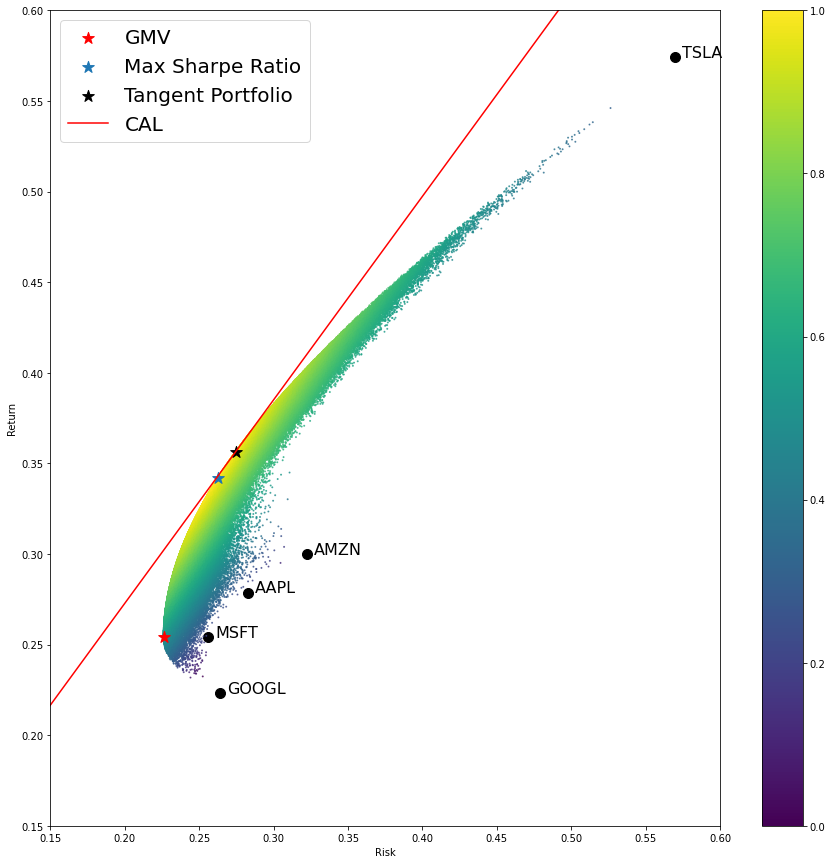

In [13]:
#Efficient Frontier

mvport = eff.iloc[eff['Stds'].idxmin()]
mvport2 = eff.iloc[eff['Sharpe'].idxmax()]
mvport3 = eff.iloc[eff['Tangent'].idxmax()]

plt.subplots(figsize= [15,15])
plt.scatter(spot['std'], spot['mean'], marker = 'o', s=100, color = 'k')
plt.scatter(eff['Stds'], eff['Returns'], marker= 'o', s = 1, alpha =0.7, c = eff['Sharpe'], cmap ='viridis')
plt.scatter(mvport[1], mvport[0], color = 'r', marker = '*', s = 150, label ="GMV")
plt.scatter(mvport2[1], mvport2[0], marker = '*', s = 150, label ="Max Sharpe Ratio")
plt.scatter(mvport3[1], mvport3[0], color = 'k', marker = '*', s = 150, label = "Tangent Portfolio")
plt.scatter(0, rf_rate, color = 'k',marker = 's', s = 150)
plt.plot([0, 2* mvport3[1],], [rf_rate, 2*mvport3[0]-rf_rate], color = 'red', label = 'CAL')
for i in range(spot.shape[0]):
    plt.text(x=spot['std'][i]+0.005, y=spot['mean'][i], s = spot.index[i], fontsize =16)
plt.colorbar()
plt.xlim(0.15,0.6)
plt.ylim(0.15,0.6)
plt.xlabel('Risk')
plt.ylabel("Return")
plt.legend(loc=2, fontsize = 20)
plt.show

In [115]:
try :
    from scipy import optimize as op
except :
    ! pip install scipy
    from scipy import optimize as op

#GMV Portfolio
def gmv(x):
    return (np.dot(x.T, np.dot(ret.cov()* 252, x)))

def gmvportfolio(x):
    x0 = [1/len(x.columns) for i in range(len(x.columns))]
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}, )  #가중치의 합= 1
    bound = (0.0001, 1.0)
    bounds =tuple(bound for i in range(len(x.columns))) #Long only
    options = {'ftol' : 1e-20, }

    sol = op.minimize(gmv, x0, constraints = constraints, 
                    bounds = bounds, options = options, method='SLSQP',)
    return sol




In [116]:
gmv_wgt =gmvportfolio(ret).x.transpose()
gmv_ret = np.sum(ret.mean() * gmv_wgt * 252)
gmv_std = np.sqrt(gmvportfolio(ret).fun)


gmv_wgt2 = pd.DataFrame(gmv_wgt).T
gmv_wgt2.columns = ret.columns
dt2 = {"Returns" : gmv_ret, 'Stds' : gmv_std}
dt2 = pd.DataFrame(dt2, index = [0])

eff2 = pd.concat([dt2, gmv_wgt2], axis =1)

eff2.T



,0
Returns,0.25460
Stds,0.22598
AAPL,0.24666
GOOGL,0.30547
MSFT,0.36320
AMZN,0.08457
TSLA,0.00010


In [117]:
mvport = pd.DataFrame(mvport)

compare = pd.concat([eff2.T, mvport], axis = 1)
compare.columns = ['Opt', 'Trial']

compare

,Opt,Trial
Returns,0.25460,0.25523
Stds,0.22598,0.22601
AAPL,0.24666,0.24161
GOOGL,0.30547,0.29364
MSFT,0.36320,0.37389
AMZN,0.08457,0.09033
TSLA,0.00010,0.00051


Chapter4 CAPM

In [73]:
#CML : 시장포트폴리오를 무위험 자산의 투자배분을 통해 나온 자본 배분선

#시장포트폴리오 : SP500

mkt_data = web.get_data_yahoo('^sp1500', '2010-06-30', end_date)['Adj Close']
mkt = mkt_data.pct_change().dropna()
mkt_data = mkt_data/mkt_data[0] * 100
mkt_return = mkt.mean() * 252
mkt_var = mkt.var() * 252
mkt_std = mkt_var ** (1/2)

<function matplotlib.pyplot.show(close=None, block=None)>

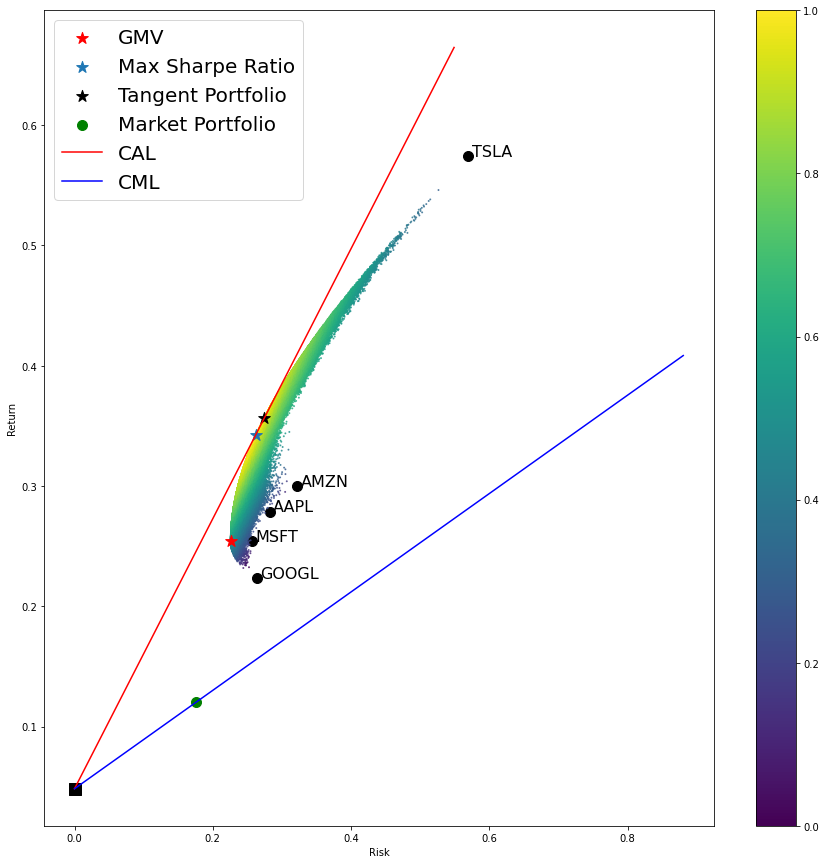

In [55]:
plt.subplots(figsize= [15,15])
plt.scatter(spot['std'], spot['mean'], marker = 'o', s=100, color = 'k')
plt.scatter(eff['Stds'], eff['Returns'], marker= 'o', s = 1, alpha =0.7, c = eff['Sharpe'], cmap ='viridis')
plt.scatter(mvport[1], mvport[0], color = 'r', marker = '*', s = 150, label ="GMV")
plt.scatter(mvport2[1], mvport2[0], marker = '*', s = 150, label ="Max Sharpe Ratio")
plt.scatter(mvport3[1], mvport3[0], color = 'k', marker = '*', s = 150, label = "Tangent Portfolio")
plt.scatter(0, rf_rate, color = 'k',marker = 's', s = 150)
plt.scatter(mkt_std, mkt_return, color = 'g', s= 100, label ='Market Portfolio')
plt.plot([0, 2* mvport3[1],], [rf_rate, 2*mvport3[0]-rf_rate], color = 'red', label = 'CAL')
for i in range(spot.shape[0]):
    plt.text(x=spot['std'][i]+0.005, y=spot['mean'][i], s = spot.index[i], fontsize =16)

plt.plot([0, 5*mkt_std], [rf_rate, 5*mkt_return - 4* rf_rate], color = 'blue', label = 'CML')

plt.colorbar()
#plt.xlim(0.15,0.6)
#plt.ylim(0.15,0.6)
plt.xlabel('Risk')
plt.ylabel("Return")
plt.legend(loc=2, fontsize = 20)
plt.show

In [82]:
#Portfolio beta

data_beta = pd.concat([data, mkt_data], axis = 1)

data_beta.columns = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']

ret_beta = data_beta.pct_change().dropna()
mean_beta = ret_beta.mean() * 252
var_beta = ret_beta.var() * 252
std_beta = np.sqrt(var_beta)
cov_beta = ret_beta.cov()* 252


In [89]:
beta = cov_beta[-1:]/cov_beta.iloc[-1,-1]

In [150]:
def beta(ticker, start, end):
    data= web.get_data_yahoo(ticker, start, end)['Adj Close']
    market = web.get_data_yahoo('^sp1500', start, end)['Adj Close']
    data_beta = pd.concat([data, market], axis = 1)
    ret_beta = data_beta.pct_change().dropna()
    mean_beta = ret_beta.mean() * 252
    var_beta = ret_beta.var() * 252
    std_beta = np.sqrt(var_beta)
    cov_beta = ret_beta.cov()* 252
    beta = cov_beta[-1:]/((cov_beta.iloc[-1,-1]))
    beta.index = ['Beta']
    
    return beta, mean_beta, std_beta


In [148]:
beta_asset, return_asset, std_asset =beta(ticker, '2017-07-01', end_date)

,AAPL,GOOGL,MSFT,AMZN,TSLA,Adj Close
Beta,27.902958,25.655402,27.40785,23.634185,33.289531,23.397994


In [117]:
def ex_ret (ticker, start_date, end_date):
    beta_asset, return_asset, std_asset =beta(ticker, start_date, end_date)
    ex_ret = rf_rate + beta_asset *(return_asset[-1] - rf_rate)
    ex_ret.index = ['expected_return']
    return(ex_ret)

In [141]:
ex_ret(ticker, '2017-07-01', end_date)

,AAPL,GOOGL,MSFT,AMZN,TSLA,Adj Close
expected_return,0.119066,0.113362,0.117809,0.108232,0.132738,0.107632
